# AE4 Recommender Challenge EDSA
#### Unsupervised_learning_AE4_DSFT21
<div style="width:100%;text-align: center;"> <img align=middle src="https://github.com/Jean-LucVanZyl/unsupervised-predict-streamlit-template/blob/fca0aedd189023bfd5537732290b66e3df797de2/Images/0f22ad161f0a604907d6447f6c88da78.png?raw=true'" alt="Heat beating" style="height:500px;margin-top:3rem;"> </div>

## Table of Contents

1. <a href ="#1.-Challenge-Description">Challenge Description</a>
2. <a href ="#2.-Evaluation-Metric">Evaluation Metric</a>
3. <a href ="#3.-Comet-Experiment">Comet Experiment</a>
3. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#5.-Importing-Data">Importing Data</a>
5. <a href ="#6.-Dimensionality-Reduction">Dimensionality Reduction</a>
6. <a href ="#6.-Model-Building">Model Building</a>
7. <a href ="#7.-Conclusion">Conclusion</a>




In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#for our kaggle notebook

## 1. Challenge Description

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging US to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## 2. Evaluation Metric

The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error  is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

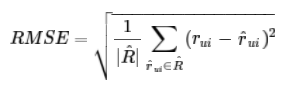
Where \\( \hat{R} \\) is the total number of recommendations generated for users and movies, with \\( r_{ui} \\) and \\( \hat{r}_{ui} \\) being the true and predicted ratings for user \\( u \\) watching movie \\( i \\) respectively.

## 3. Comet Experiment 

In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="1AwUmDPCaKw7TZWLKwrSQ2n9z",
    project_name="general",
    workspace="jean-lucvanzyl",
)



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jean-lucvanzyl/general/c96b6c11737a4893bad4a818cd27d9a9



## 4. Importing Libraries
In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [3]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

#Seaborn

import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [35]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 5. Importing Data

In [4]:
#Movies dataframe
movies_df = pd.read_csv('movies.csv')

#Genome_scores dataframe
gs_df = pd.read_csv('genome_scores.csv')

#Genome_tags dataframe
gt_df = pd.read_csv('genome_tags.csv')

#imbd dataframe
imdb_df = pd.read_csv('imdb_data.csv')

#links dataframe
links_df = pd.read_csv('links.csv')

#tags dataframe
tags_df = pd.read_csv('tags.csv')

#train dataframe
train_df = pd.read_csv('train.csv')

#test dataframe 
test_df = pd.read_csv('test.csv')

#sample submission
sample_df = pd.read_csv('sample_submission.csv')


We need to determine the rating score for the respective movieId and submit a csv file in that format for the Kaggle competition. Lets take a look at the features and shape of our training data and a quick look at our movies dataframe.

In [5]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
train_df.shape

(10000038, 4)

Looking at the shape of the dataframe, we find we have 4 columns and more than 10 million observations, which is going to require a fair bit of processing power to work through. The column names are User ID, Movie ID, Rating and Timestamp. All of the data to train our model upon has numerical data types, perfect for unsupervised learning. The columns aren't measured on the same scale, so lets scale the data first and afterwards apply dimensionality reduction.

#### Lets create a dataframe of the different movie genres.

In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


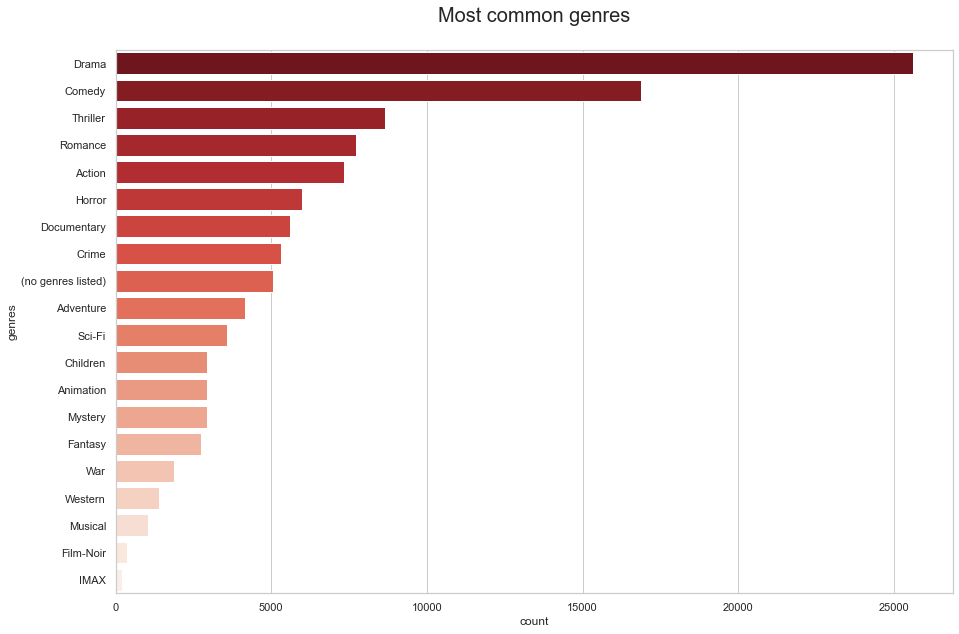

In [24]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

Drama and Comedy are the most popular genres, followed by Thriller and Romance. We need to keep in mind that the movies could have multiple genres.

In [25]:
movies_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## 5. Scales of measurement

Scaling data is vitally important because not all variables are measured on the same scales and/or using the same units. We can clearly see that the mean of the Rating column would be substantially lower than the mean of the Movie ID column.

In [28]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


Lets scale the data.

In [45]:
# declare the features to be all columns from our movies_df
features = [col for col in train_df.columns]

# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
scaled_df = pd.read_csv('train.csv')
scaled_df[features] = preprocessing.scale(scaled_df[features])

In [46]:
scaled_df

,userId,movieId,rating,timestamp
0,-1.624926,0.925607,0.439727,1.333994
1,0.537337,-0.545572,0.910925,-0.041600
2,1.401707,-0.406424,1.382124,-0.614662
3,0.537743,0.278267,-1.445067,0.913937
4,-1.542051,-0.536362,-0.502670,-1.684949
...,...,...,...,...
10000033,1.179562,1.982991,1.382124,1.346709
10000034,1.258269,-0.531591,-0.502670,-0.939198
10000035,1.573034,0.902977,0.439727,0.052877
10000036,0.098430,-0.537357,0.439727,1.164625


## 6. Dimensionality Reduction

The problems with increasing or high levels of dimensionality of our dataframes are as follows:

- More storage space required for the data;
- More computation time required to work with the data; and
- More features mean more chance of feature correlation, and hence feature redundancy.

For the reasons above, lets apply Principle Component Analysis (PCA).

## Principal Component Analysis
The premise of PCA is that data in some higher number of dimensions can be mapped to some lower number of dimensions, whilst retaining the maximum amount of variance in the lower dimension. Lets apply the following steps;
1. Perform feature scaling on our data; 
2. Construct the covariance matrix of the data;
3. Compute the eigenvectors of this matrix; and Eigenvectors corresponding to the largest eigenvalues are used to reconstruct a maximal fraction of variance of the original data.

Text(0, 0.5, 'Cumulative explained variance')

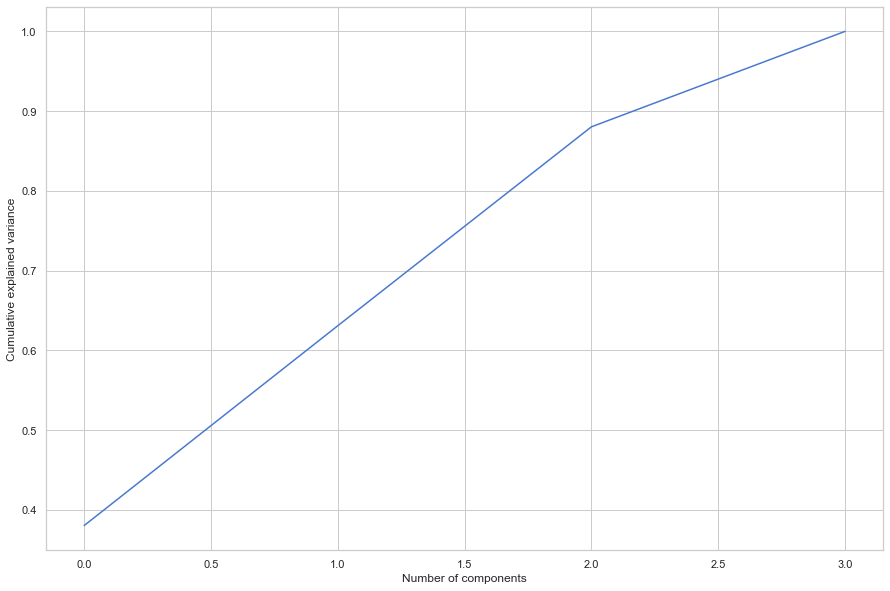

In [47]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(scaled_df[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)



# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [48]:
pca_85 = PCA(.85)
pca_85.fit_transform(scaled_df[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

88.0 % of variance explained by 3 components.


In [49]:
pca.explained_variance_ratio_[:3]

array([0.3802045 , 0.25060905, 0.24947369])

In this instance, the first component explains 38%, with the 2nd following behind at 25% and the 3rd at 25% as well. Together, these components explain 88% of the data.

Let's plot the first two components on a 2D scatter plot.

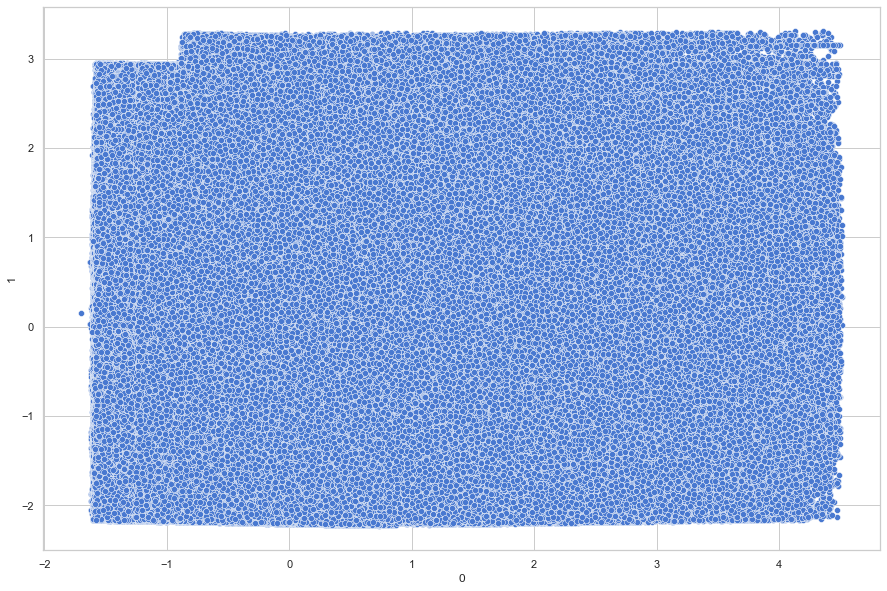

In [52]:
ax = sns.scatterplot(x=pca_df[0], y=pca_df[1],
                    
                     palette='RdBu',
                     data=pca_df,
                     legend=False)
plt.show()

Hahaha ahh guess this doesn't help much with EDA hey AE4! We have too many datapoints!

In [ ]:
# exclude non-features from data
reg_data = us_df_scaled[features]

# set aside response variable (Unscaled!)
reg_response = us_df["IncomePerCap"]

# drop response variable
reg_data = reg_data.drop(['IncomePerCap'], 1)

## Putting Our Dimensionality Reduction to Use
Lets build a predictive regressor model.

We will use the feature named `Rating` as the response variable (the one that we will try to predict). This feature was used in our initial PCA, so we will have to make some changes to the dataset to ensure it is not included this time.

PCA requires features to be scaled, as we mentioned above. But we don't need to scale the response variable which we will use for prediction, as it is not used in PCA. This is good, because leaving the response as is means any predicted values and associated errors are easier to interpret. 

In [53]:
# exclude non-features from data
reg_data = scaled_df[features]

# set aside response variable (Unscaled!)
reg_response = train_df["rating"]

# drop response variable
reg_data = reg_data.drop(['rating'], 1)

Now, let's split the dataset up into train and test using with a ration of 80 percent training data and 20 percent testing data.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

Next, we apply PCA to the training set with the number of components set to 3.

In [58]:
# create PCA object with n_components set to 2
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

2

In [59]:
pca_reg.explained_variance_ratio_.sum()

0.8402568376414348

Fantastic, 84 percent of the variance is captured with these 2 components. Let's continue by applying the same reduction transformation to the test set and make use of a random forest regression model for our predictions.

In [60]:
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, n_jobs=-1, random_state = 101)

# train the model on training data
rf.fit(X_train, y_train)

MemoryError: could not allocate 469762048 bytes